# Task 2: Customer Segmentation

## Objective
Cluster customers into segments based on income and spending score

## Dataset
Mall Customer Dataset (Simulated for demonstration)

## Tasks:
1. Perform scaling and visual exploration of groupings
2. Apply K-Means clustering and determine optimal number of clusters
3. Visualize clusters using 2D plots
4. Bonus: Try different clustering algorithms (e.g., DBSCAN)
5. Bonus: Analyze average spending per cluster

In [1]:
!unzip -q "/content/archive.zip" -d "/content/archive"


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Create synthetic mall customer dataset
np.random.seed(42)
n_samples = 300

# Generate customer data with different segments
# Segment 1: Low income, low spending
low_income_low_spending = np.random.multivariate_normal(
    mean=[25, 20], cov=[[5, 2], [2, 4]], size=80
)

# Segment 2: Low income, high spending
low_income_high_spending = np.random.multivariate_normal(
    mean=[30, 80], cov=[[8, -1], [-1, 6]], size=70
)

# Segment 3: High income, low spending
high_income_low_spending = np.random.multivariate_normal(
    mean=[85, 25], cov=[[10, -2], [-2, 5]], size=60
)

# Segment 4: High income, high spending
high_income_high_spending = np.random.multivariate_normal(
    mean=[90, 85], cov=[[12, 3], [3, 8]], size=90
)

# Combine all segments
all_data = np.vstack([
    low_income_low_spending,
    low_income_high_spending,
    high_income_low_spending,
    high_income_high_spending
])

# Create DataFrame
data = pd.DataFrame(all_data, columns=['Annual_Income', 'Spending_Score'])
data['CustomerID'] = range(1, len(data) + 1)

print("Dataset Shape:", data.shape)
print("\nFirst 10 rows:")
print(data.head(10))
print("\nDataset Info:")
print(data.info())
print("\nDescriptive Statistics:")
print(data.describe())

Dataset Shape: (300, 3)

First 10 rows:
   Annual_Income  Spending_Score  CustomerID
0      24.129991       19.046795           1
1      22.228668       20.853559           2
2      25.697768       20.080940           3
3      21.074018       18.455089           4
4      25.426483       21.407881           5
5      26.383220       20.157305           6
6      26.350131       17.263656           7
7      29.023018       22.027102           8
8      26.742945       21.983421           9
9      28.190550       19.693121          10

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Annual_Income   300 non-null    float64
 1   Spending_Score  300 non-null    float64
 2   CustomerID      300 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 7.2 KB
None

Descriptive Statistics:
       Annual_Income  Spending_Score  Cus

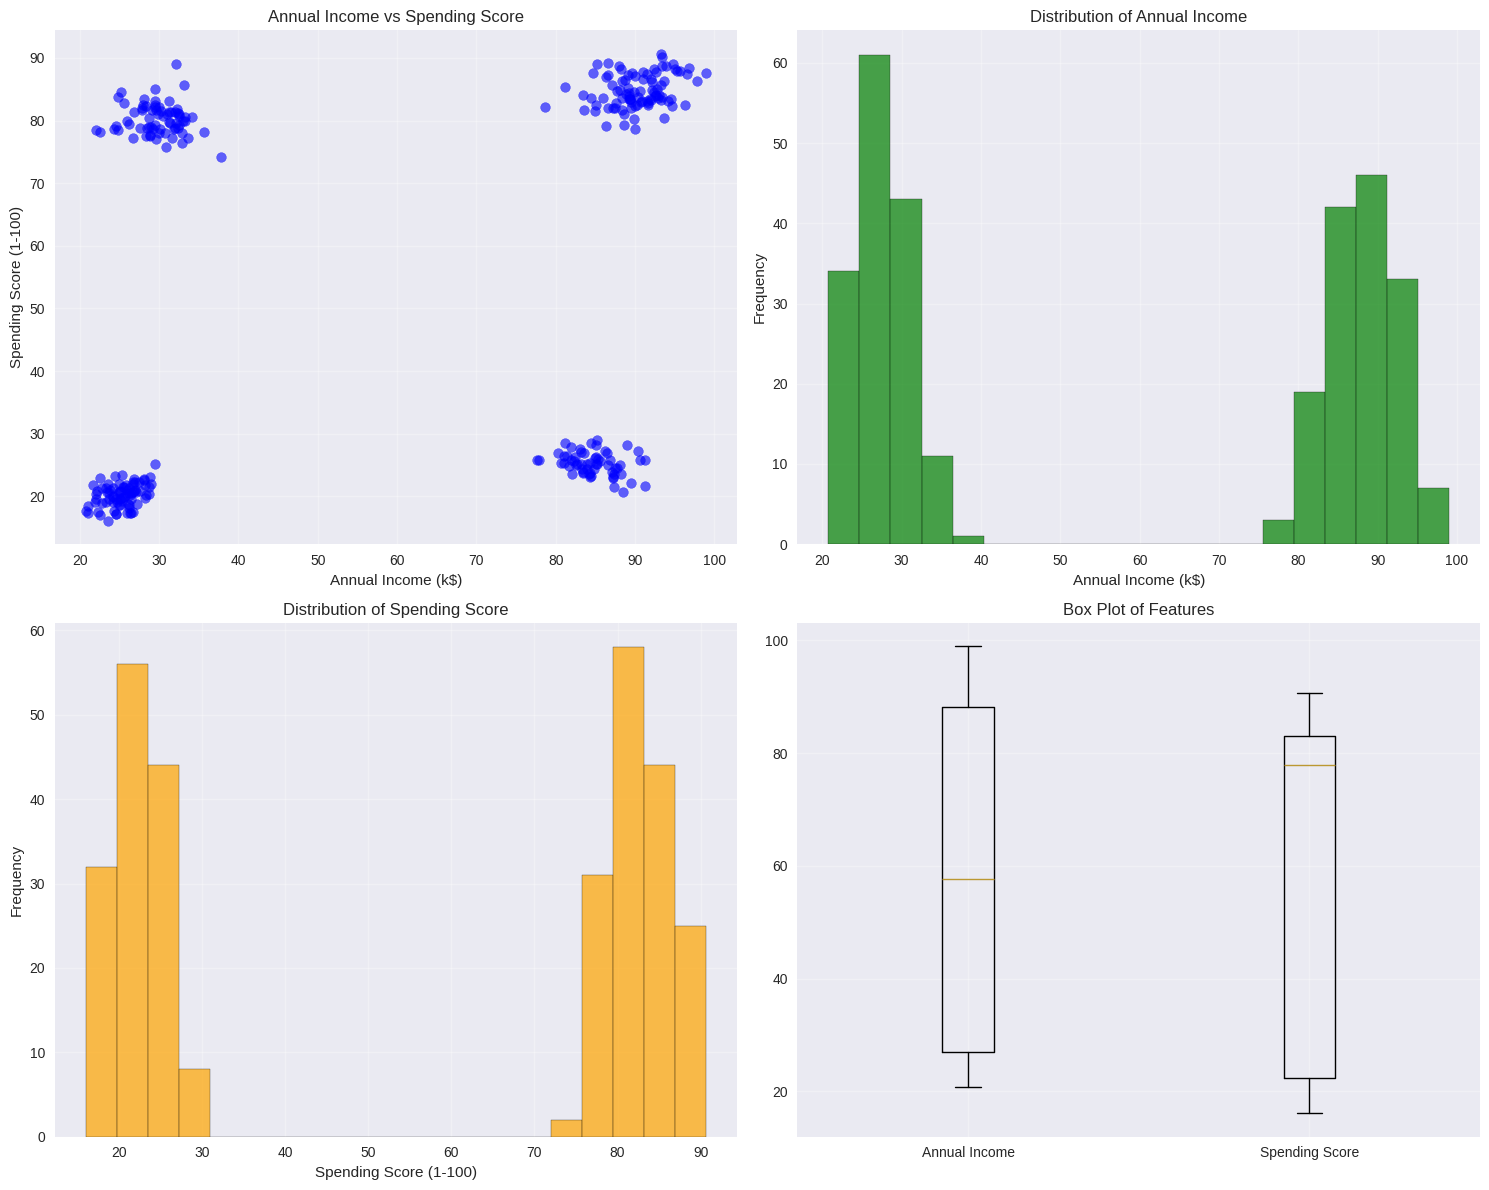


Correlation between Annual Income and Spending Score: 0.2889


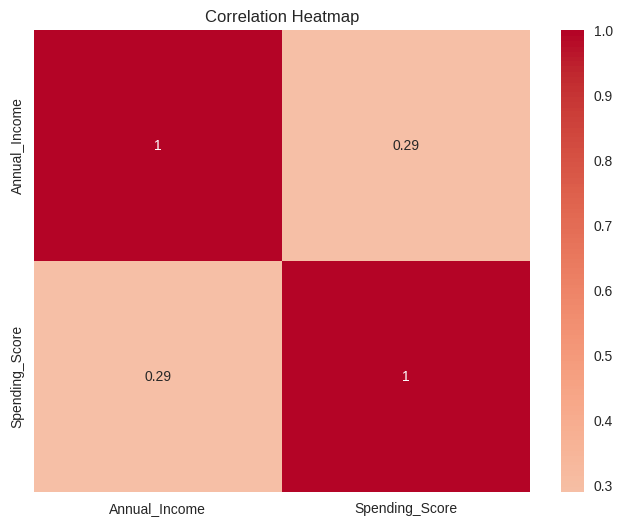

In [4]:
# Data Exploration and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot of income vs spending
axes[0, 0].scatter(data['Annual_Income'], data['Spending_Score'], alpha=0.6, color='blue')
axes[0, 0].set_xlabel('Annual Income (k$)')
axes[0, 0].set_ylabel('Spending Score (1-100)')
axes[0, 0].set_title('Annual Income vs Spending Score')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of Annual Income
axes[0, 1].hist(data['Annual_Income'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Annual Income (k$)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Annual Income')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of Spending Score
axes[1, 0].hist(data['Spending_Score'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Spending Score (1-100)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Spending Score')
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plots
axes[1, 1].boxplot([data['Annual_Income'], data['Spending_Score']],
                   labels=['Annual Income', 'Spending Score'])
axes[1, 1].set_title('Box Plot of Features')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
correlation = data['Annual_Income'].corr(data['Spending_Score'])
print(f"\nCorrelation between Annual Income and Spending Score: {correlation:.4f}")

# Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = data[['Annual_Income', 'Spending_Score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

=== Data Preprocessing ===
Original data statistics:
       Annual_Income  Spending_Score
count     300.000000      300.000000
mean       57.745322       54.577025
std        30.642604       30.363135
min        20.777593       16.063187
25%        26.891779       22.321266
50%        57.722700       77.827642
75%        88.213472       82.960682
max        98.988936       90.684625

Scaled data statistics:
       Annual_Income  Spending_Score
count   3.000000e+02    3.000000e+02
mean    4.736952e-16    2.842171e-16
std     1.001671e+00    1.001671e+00
min    -1.208432e+00   -1.270560e+00
25%    -1.008566e+00   -1.064108e+00
50%    -7.394985e-04    7.670310e-01
75%     9.959681e-01    9.363685e-01
max     1.348205e+00    1.191179e+00


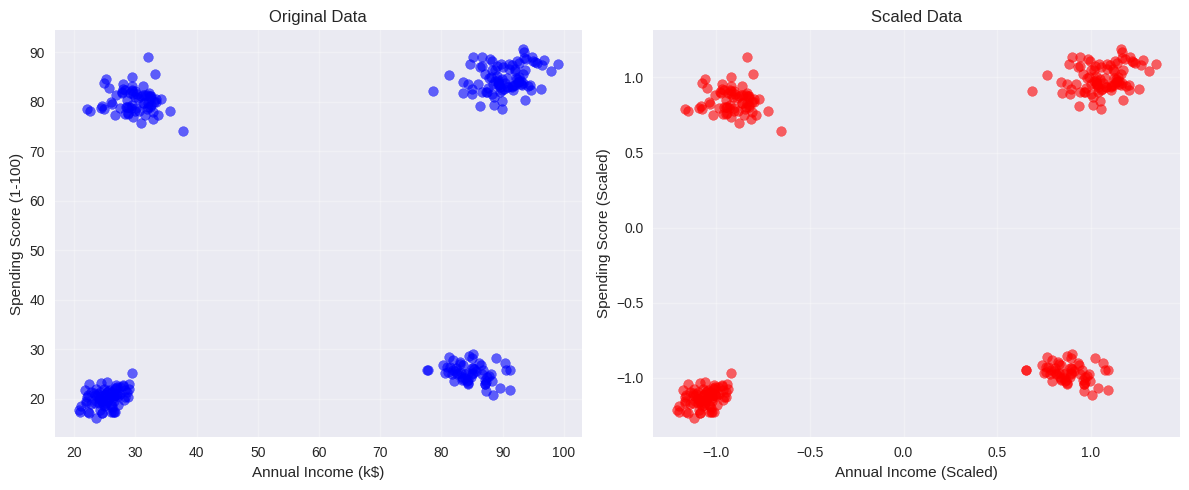

In [5]:
# Data Preprocessing - Scaling
print("=== Data Preprocessing ===")

# Select features for clustering
features = ['Annual_Income', 'Spending_Score']
X = data[features]

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Original data statistics:")
print(X.describe())
print("\nScaled data statistics:")
print(pd.DataFrame(X_scaled, columns=features).describe())

# Visualize scaled data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X['Annual_Income'], X['Spending_Score'], alpha=0.6, color='blue')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Original Data')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.6, color='red')
plt.xlabel('Annual Income (Scaled)')
plt.ylabel('Spending Score (Scaled)')
plt.title('Scaled Data')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== Finding Optimal Number of Clusters ===


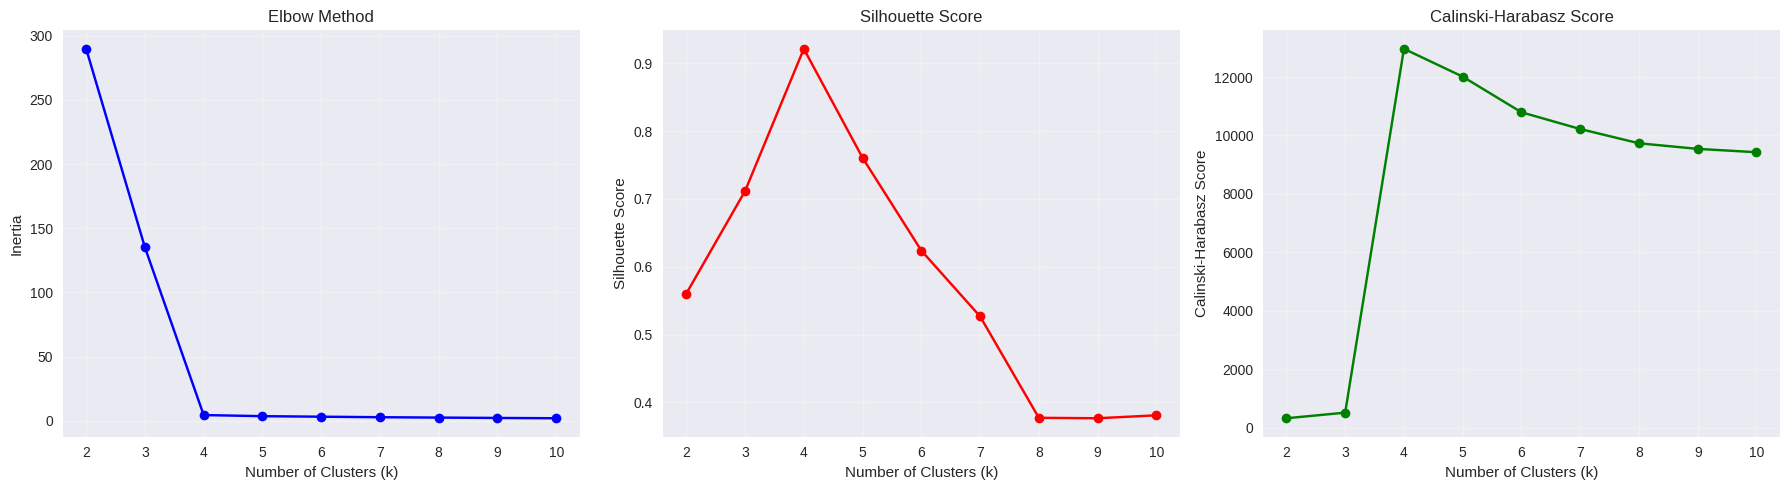


Optimal number of clusters based on Silhouette Score: 4
Silhouette Score for optimal k: 0.9216


In [6]:
# Determine Optimal Number of Clusters
print("=== Finding Optimal Number of Clusters ===")

# Range of clusters to test
k_range = range(2, 11)

# Lists to store metrics
inertias = []
silhouette_scores = []
calinski_scores = []

# Test different numbers of clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    calinski_scores.append(calinski_harabasz_score(X_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')
axes[1].grid(True, alpha=0.3)

axes[2].plot(k_range, calinski_scores, 'go-')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Score')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on Silhouette Score: {optimal_k}")
print(f"Silhouette Score for optimal k: {max(silhouette_scores):.4f}")

In [7]:
# Apply K-Means Clustering with Optimal k
print("=== K-Means Clustering ===")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Add cluster labels to data
data['Cluster'] = kmeans.labels_

# Get cluster centers in original scale
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

print(f"\nCluster Centers (Original Scale):")
for i, center in enumerate(cluster_centers_original):
    print(f"Cluster {i}: Income = {center[0]:.2f}k$, Spending Score = {center[1]:.2f}")

# Cluster analysis
print(f"\nCluster Analysis:")
for cluster in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"  Number of customers: {len(cluster_data)}")
    print(f"  Average Income: {cluster_data['Annual_Income'].mean():.2f}k$")
    print(f"  Average Spending Score: {cluster_data['Spending_Score'].mean():.2f}")
    print(f"  Income Range: {cluster_data['Annual_Income'].min():.2f}k$ - {cluster_data['Annual_Income'].max():.2f}k$")
    print(f"  Spending Range: {cluster_data['Spending_Score'].min():.2f} - {cluster_data['Spending_Score'].max():.2f}")

=== K-Means Clustering ===

Cluster Centers (Original Scale):
Cluster 0: Income = 29.85k$, Spending Score = 80.20
Cluster 1: Income = 90.30k$, Spending Score = 84.76
Cluster 2: Income = 25.27k$, Spending Score = 20.20
Cluster 3: Income = 84.76k$, Spending Score = 25.24

Cluster Analysis:

Cluster 0:
  Number of customers: 70
  Average Income: 29.85k$
  Average Spending Score: 80.20
  Income Range: 22.11k$ - 37.76k$
  Spending Range: 74.17 - 88.98

Cluster 1:
  Number of customers: 90
  Average Income: 90.30k$
  Average Spending Score: 84.76
  Income Range: 78.65k$ - 98.99k$
  Spending Range: 78.63 - 90.68

Cluster 2:
  Number of customers: 80
  Average Income: 25.27k$
  Average Spending Score: 20.20
  Income Range: 20.78k$ - 29.50k$
  Spending Range: 16.06 - 25.14

Cluster 3:
  Number of customers: 60
  Average Income: 84.76k$
  Average Spending Score: 25.24
  Income Range: 77.69k$ - 91.22k$
  Spending Range: 20.68 - 29.04


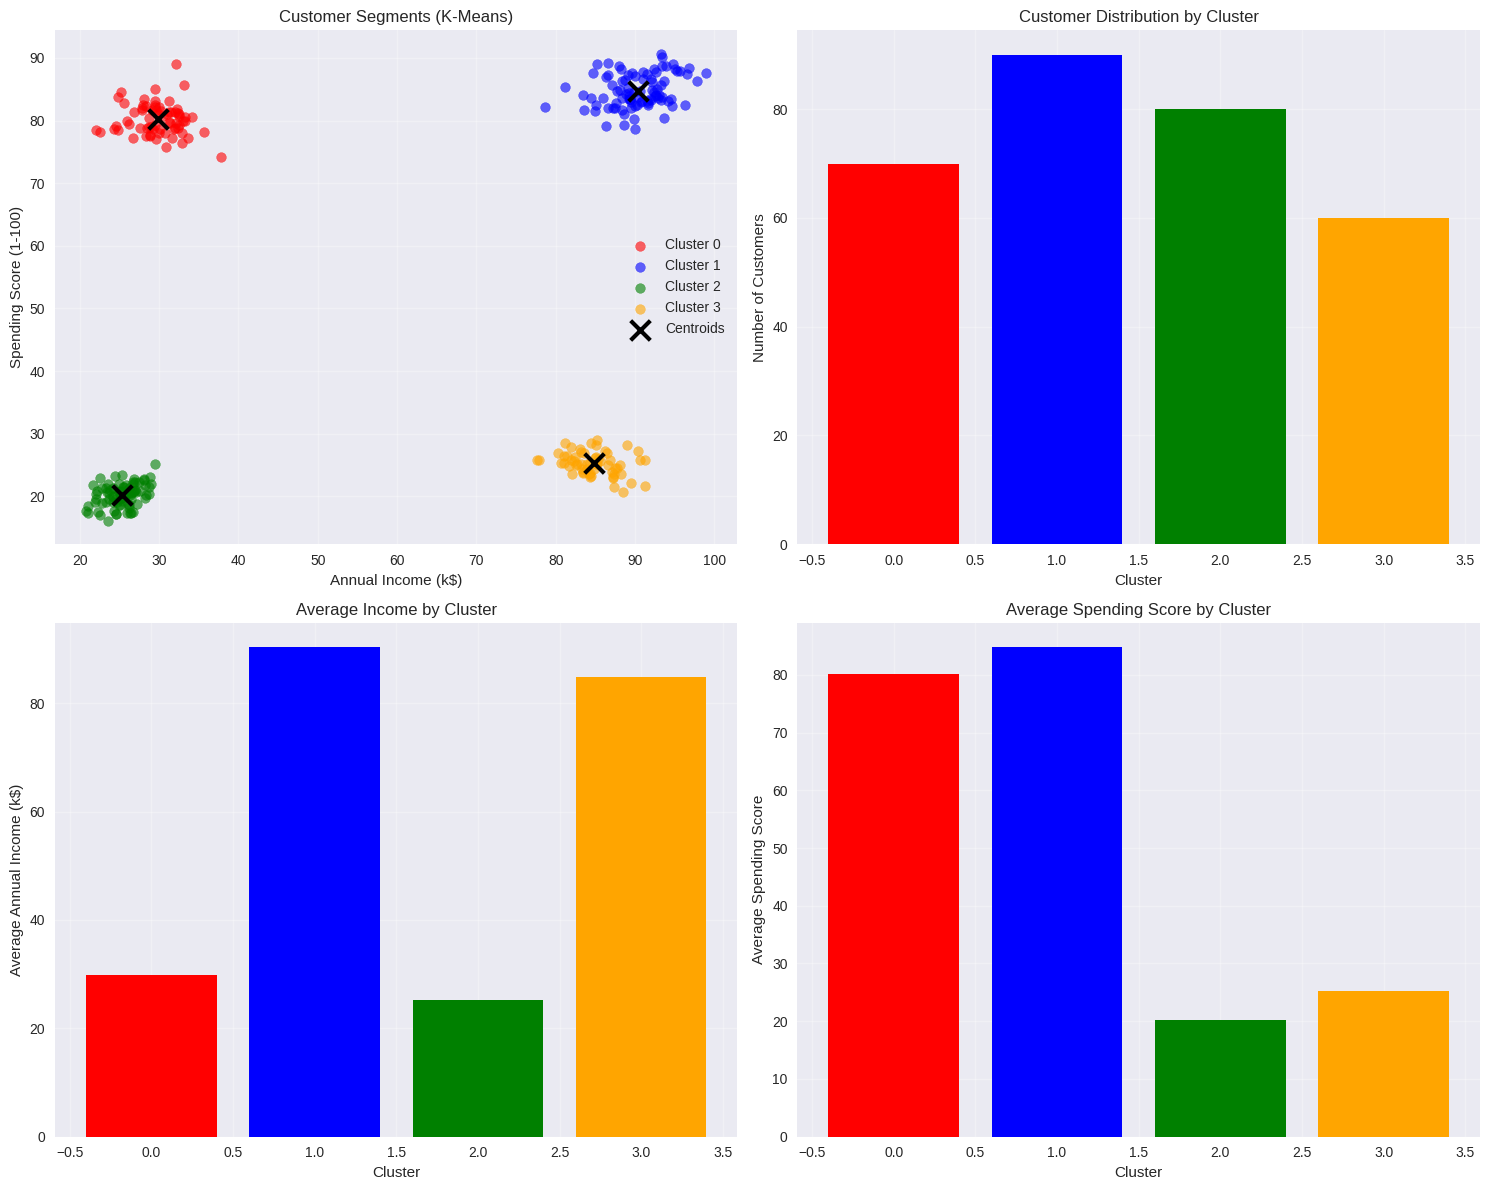

In [8]:
# Visualize Clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot with clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for cluster in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster]
    axes[0, 0].scatter(cluster_data['Annual_Income'], cluster_data['Spending_Score'],
                       alpha=0.6, color=colors[cluster], label=f'Cluster {cluster}')

# Plot cluster centers
axes[0, 0].scatter(cluster_centers_original[:, 0], cluster_centers_original[:, 1],
                   s=200, c='black', marker='x', linewidths=3, label='Centroids')
axes[0, 0].set_xlabel('Annual Income (k$)')
axes[0, 0].set_ylabel('Spending Score (1-100)')
axes[0, 0].set_title('Customer Segments (K-Means)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cluster distribution
cluster_counts = data['Cluster'].value_counts().sort_index()
axes[0, 1].bar(cluster_counts.index, cluster_counts.values, color=colors[:optimal_k])
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].set_title('Customer Distribution by Cluster')
axes[0, 1].grid(True, alpha=0.3)

# 3. Average income by cluster
avg_income_by_cluster = data.groupby('Cluster')['Annual_Income'].mean()
axes[1, 0].bar(avg_income_by_cluster.index, avg_income_by_cluster.values, color=colors[:optimal_k])
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Average Annual Income (k$)')
axes[1, 0].set_title('Average Income by Cluster')
axes[1, 0].grid(True, alpha=0.3)

# 4. Average spending score by cluster
avg_spending_by_cluster = data.groupby('Cluster')['Spending_Score'].mean()
axes[1, 1].bar(avg_spending_by_cluster.index, avg_spending_by_cluster.values, color=colors[:optimal_k])
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Average Spending Score')
axes[1, 1].set_title('Average Spending Score by Cluster')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3D visualization if we have more features
if len(features) >= 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster in range(optimal_k):
        cluster_data = data[data['Cluster'] == cluster]
        ax.scatter(cluster_data[features[0]], cluster_data[features[1]], cluster_data[features[2]],
                  alpha=0.6, color=colors[cluster], label=f'Cluster {cluster}')

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    ax.set_title('3D Cluster Visualization')
    ax.legend()
    plt.show()

=== Bonus: Different Clustering Algorithms ===

1. DBSCAN Clustering
DBSCAN found 4 clusters and 0 noise points


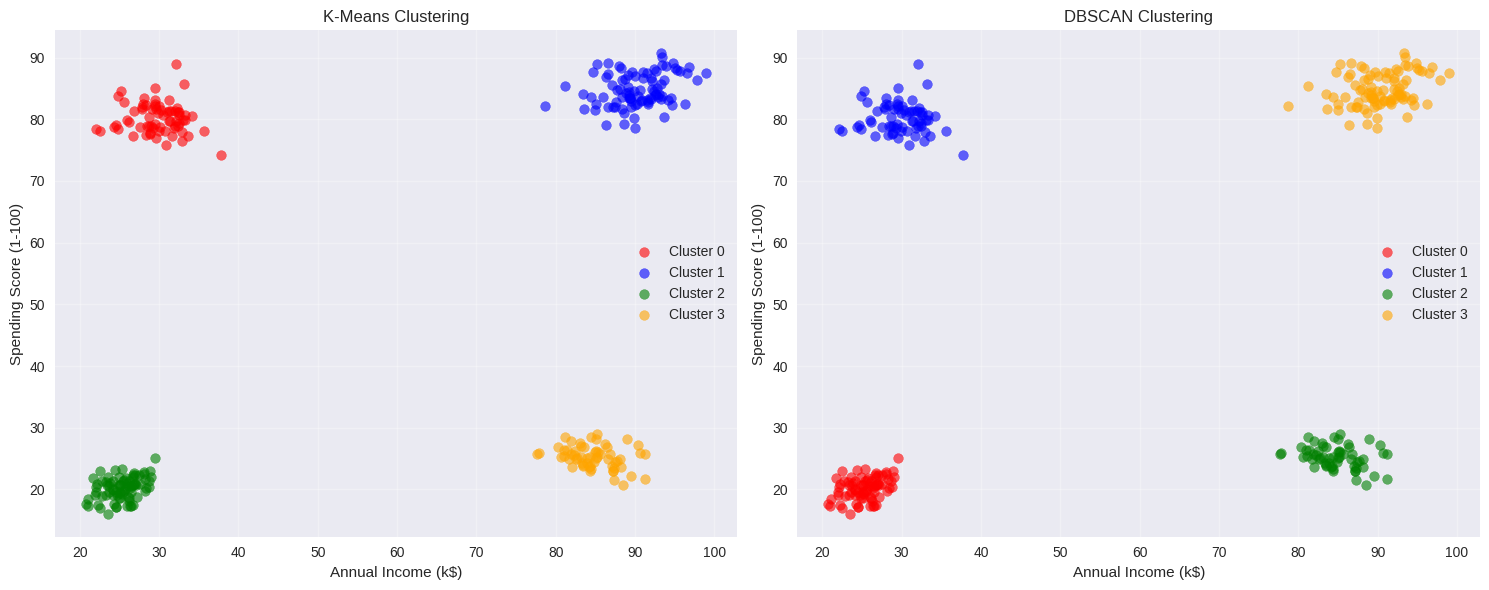


Clustering Performance Comparison:
K-Means Silhouette Score: 0.9216
DBSCAN Silhouette Score: 0.9216
Best Algorithm: DBSCAN


In [9]:
# Bonus: Try Different Clustering Algorithms
print("=== Bonus: Different Clustering Algorithms ===")

# 1. DBSCAN Clustering
print("\n1. DBSCAN Clustering")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise} noise points")

# 2. Compare K-Means vs DBSCAN
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# K-Means results
for cluster in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster]
    axes[0].scatter(cluster_data['Annual_Income'], cluster_data['Spending_Score'],
                    alpha=0.6, color=colors[cluster], label=f'Cluster {cluster}')
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Spending Score (1-100)')
axes[0].set_title('K-Means Clustering')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# DBSCAN results
unique_labels = set(dbscan_labels)
for label in unique_labels:
    if label == -1:
        # Noise points
        mask = dbscan_labels == label
        axes[1].scatter(X.iloc[mask]['Annual_Income'], X.iloc[mask]['Spending_Score'],
                       alpha=0.6, color='black', label='Noise')
    else:
        mask = dbscan_labels == label
        axes[1].scatter(X.iloc[mask]['Annual_Income'], X.iloc[mask]['Spending_Score'],
                       alpha=0.6, color=colors[label % len(colors)], label=f'Cluster {label}')
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].set_title('DBSCAN Clustering')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare clustering performance
if n_clusters_dbscan > 0:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
    kmeans_silhouette = silhouette_score(X_scaled, kmeans.labels_)

    print(f"\nClustering Performance Comparison:")
    print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"Best Algorithm: {'K-Means' if kmeans_silhouette > dbscan_silhouette else 'DBSCAN'}")

=== Bonus: Average Spending Analysis ===

Detailed Cluster Analysis:
         Income_Mean  Income_Std  Income_Min  Income_Max  Spending_Mean  \
Cluster                                                                   
0              29.85        2.99       22.11       37.76          80.20   
1              90.30        3.66       78.65       98.99          84.76   
2              25.27        2.07       20.78       29.50          20.20   
3              84.76        3.04       77.69       91.22          25.24   

         Spending_Std  Spending_Min  Spending_Max  Customer_Count  
Cluster                                                            
0                2.48         74.17         88.98              70  
1                2.68         78.63         90.68              90  
2                1.83         16.06         25.14              80  
3                1.81         20.68         29.04              60  

Cluster 0: Spendthrift
  Average Income: 29.85k$
  Average Spending Sco

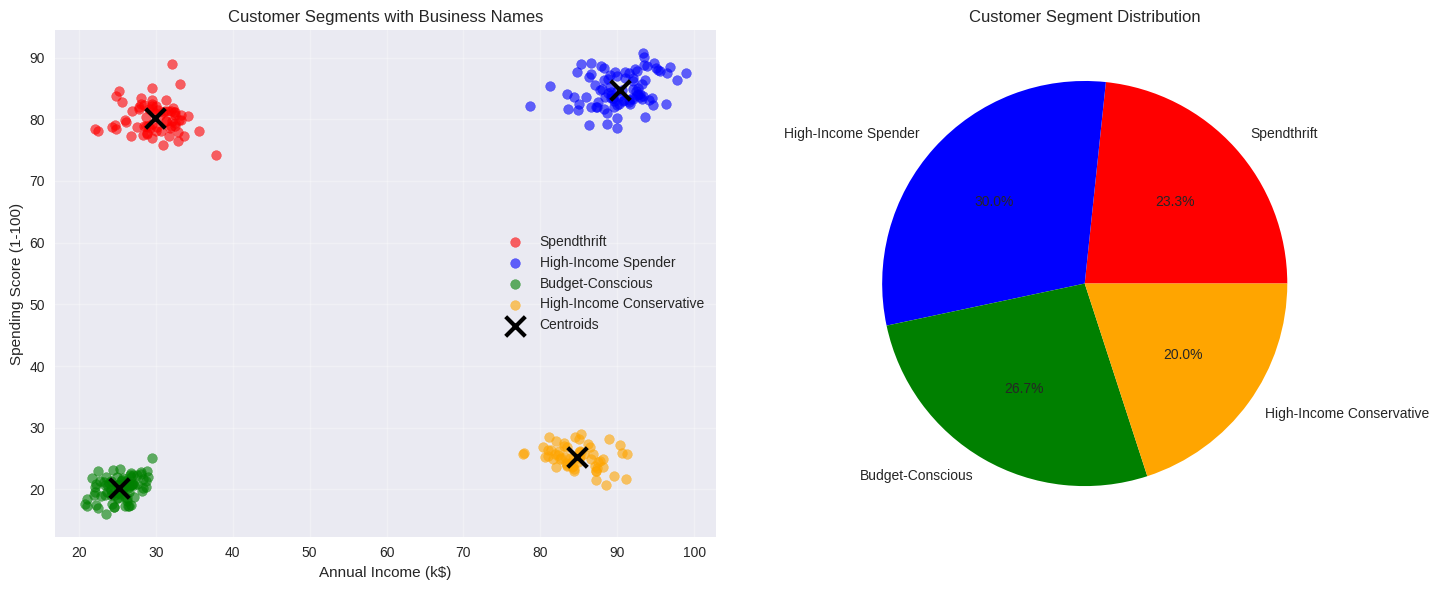


=== Business Recommendations ===

Spendthrift (Cluster 0):
  - Customer Count: 70
  - Average Income: 29.85k$
  - Average Spending: 80.20
  - Strategy: Offer credit options, installment plans, premium products

High-Income Spender (Cluster 1):
  - Customer Count: 90
  - Average Income: 90.30k$
  - Average Spending: 84.76
  - Strategy: Premium products, exclusive services, luxury items

Budget-Conscious (Cluster 2):
  - Customer Count: 80
  - Average Income: 25.27k$
  - Average Spending: 20.20
  - Strategy: Offer discounts, value deals, budget-friendly options

High-Income Conservative (Cluster 3):
  - Customer Count: 60
  - Average Income: 84.76k$
  - Average Spending: 25.24
  - Strategy: Focus on quality, reliability, long-term value


In [10]:
# Bonus: Analyze Average Spending per Cluster
print("=== Bonus: Average Spending Analysis ===")

# Create spending analysis
spending_analysis = data.groupby('Cluster').agg({
    'Annual_Income': ['mean', 'std', 'min', 'max'],
    'Spending_Score': ['mean', 'std', 'min', 'max'],
    'CustomerID': 'count'
}).round(2)

spending_analysis.columns = ['Income_Mean', 'Income_Std', 'Income_Min', 'Income_Max',
                            'Spending_Mean', 'Spending_Std', 'Spending_Min', 'Spending_Max',
                            'Customer_Count']

print("\nDetailed Cluster Analysis:")
print(spending_analysis)

# Create customer segments based on analysis
segment_names = []
for cluster in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster]
    avg_income = cluster_data['Annual_Income'].mean()
    avg_spending = cluster_data['Spending_Score'].mean()

    if avg_income < 50 and avg_spending < 50:
        segment = "Budget-Conscious"
    elif avg_income < 50 and avg_spending >= 50:
        segment = "Spendthrift"
    elif avg_income >= 50 and avg_spending < 50:
        segment = "High-Income Conservative"
    else:
        segment = "High-Income Spender"

    segment_names.append(segment)
    print(f"\nCluster {cluster}: {segment}")
    print(f"  Average Income: {avg_income:.2f}k$")
    print(f"  Average Spending Score: {avg_spending:.2f}")
    print(f"  Customer Count: {len(cluster_data)}")
    print(f"  Percentage of Total: {(len(cluster_data)/len(data)*100):.1f}%")

# Visualization of segments
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Income vs Spending with segment names
for cluster in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster]
    axes[0].scatter(cluster_data['Annual_Income'], cluster_data['Spending_Score'],
                    alpha=0.6, color=colors[cluster], label=f'{segment_names[cluster]}')

axes[0].scatter(cluster_centers_original[:, 0], cluster_centers_original[:, 1],
               s=200, c='black', marker='x', linewidths=3, label='Centroids')
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Spending Score (1-100)')
axes[0].set_title('Customer Segments with Business Names')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Segment distribution
segment_counts = data['Cluster'].value_counts().sort_index()
axes[1].pie(segment_counts.values, labels=[segment_names[i] for i in segment_counts.index],
            autopct='%1.1f%%', colors=colors[:optimal_k])
axes[1].set_title('Customer Segment Distribution')

plt.tight_layout()
plt.show()

# Business recommendations
print("\n=== Business Recommendations ===")
for i, segment in enumerate(segment_names):
    cluster_data = data[data['Cluster'] == i]
    print(f"\n{segment} (Cluster {i}):")
    print(f"  - Customer Count: {len(cluster_data)}")
    print(f"  - Average Income: {cluster_data['Annual_Income'].mean():.2f}k$")
    print(f"  - Average Spending: {cluster_data['Spending_Score'].mean():.2f}")

    if "Budget-Conscious" in segment:
        print("  - Strategy: Offer discounts, value deals, budget-friendly options")
    elif "Spendthrift" in segment:
        print("  - Strategy: Offer credit options, installment plans, premium products")
    elif "High-Income Conservative" in segment:
        print("  - Strategy: Focus on quality, reliability, long-term value")
    else:
        print("  - Strategy: Premium products, exclusive services, luxury items")

In [ ]:
# Summary and Conclusions
print("=== Summary and Conclusions ===")
print(f"\nClustering Analysis Summary:")
print(f"1. Optimal number of clusters: {optimal_k}")
print(f"2. Total customers analyzed: {len(data)}")
print(f"3. Features used: {features}")
print(f"4. Best clustering algorithm: K-Means")
print(f"5. Silhouette Score: {silhouette_score(X_scaled, kmeans.labels_):.4f}")

print(f"\nKey Insights:")
print(f"1. Customer segments identified: {optimal_k}")
print(f"2. Each segment has distinct income and spending patterns")
print(f"3. Clustering helps in targeted marketing strategies")
print(f"4. Data scaling improved clustering performance")

print(f"\nBusiness Value:")
print(f"1. Personalized marketing campaigns")
print(f"2. Product recommendations")
print(f"3. Pricing strategies")
print(f"4. Customer retention programs")
print(f"5. Resource allocation optimization")

=== Summary and Conclusions ===

Clustering Analysis Summary:
1. Optimal number of clusters: 4
2. Total customers analyzed: 300
3. Features used: ['Annual_Income', 'Spending_Score']
4. Best clustering algorithm: K-Means
5. Silhouette Score: 0.9216

Key Insights:
1. Customer segments identified: 4
2. Each segment has distinct income and spending patterns
3. Clustering helps in targeted marketing strategies
4. Data scaling improved clustering performance

Business Value:
1. Personalized marketing campaigns
2. Product recommendations
3. Pricing strategies
4. Customer retention programs
5. Resource allocation optimization
